# **Customer Segmentation**

Customer segmentation is the process of dividing customers into groups based on common characteristics such as demographics, behavior, or preferences. This is important for businesses because it allows them to tailor their marketing, sales, and customer service strategies to specific groups of customers. 

## The Objective

* Improve customer understanding: By segmenting customers, businesses gain a deeper understanding of their needs, preferences, and behaviors. This allows them to better serve their customers, create more targeted marketing campaigns, and improve customer satisfaction.

* Marketing: When businesses understand their customer segments, they can create more targeted marketing campaigns that are more likely to resonate with the intended audience. This can increase the effectiveness of marketing efforts, leading to more sales and revenue.

* Increase customer retention: Customer segmentation allows businesses to create personalized experiences for different groups of customers, which can lead to increased customer loyalty and retention.

* Cost savings: By targeting specific customer segments, businesses can save money on marketing and advertising by only reaching out to those who are most likely to buy their products or services.

By understanding their customers better, businesses can create more effective strategies that lead to customers being satisfied and thus higher revenue.

## About [Dataset](https://www.kaggle.com/datasets/dev0914sharma/customer-clustering?select=segmentation+data.csv)

The dataset contains some basic data about the customers like Customer ID, age, gender, annual income. You want to understand the customers like who are the target customers so that the sense can be given to marketing team and plan the strategy accordingly.

The goal is to find the target customer groups and identify unsatisfied customer needs. Using this kind of data companies can then outperform the competition by developing uniquely appealing products and services for the specific groups of customers.

## Problem Statement

My main goal in this project was to implement different models to identify the main groups of customers for the dataset. Also, after finding these groups, my objective was to characterize these groups with the help of visualization tools and to make an attempt at understanding consumer behaviour and gaining a deeper understanding of the challanges and opportunities within this industry.

## Steps taken to solve the problem:
1. [Imports and Useful Functions](#imports)
2. [Exploring the data](#explore)
3. [Dimensionality Reduction](#dimred)
4. [Clustering](#clustering) 
    * [KMeans](#kmeans)
    * [DBSCAN](#db)
    * [Gaussian Mixtures](#gm)
    * [Agglomerative Clustering](#agg)
5. [Clustering Comparison](#compare)
6. [Customer Profiling](#profile)
7. [Summary](#summary)
8. [Conclusions and Feature Work](#conclusion)

<a id="imports"></a>
## Imports and Useful Functions


In [1]:
# Importing the Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly
import plotly.graph_objs as go

# Configure Plotly to be rendered inline in the notebook.
plotly.offline.init_notebook_mode()

plt.style.use('ggplot') 

In [2]:
def plot_clusters3d(cluster_groups, cluster_col, title, colorscale=None, legend=True):
    '''
    Creates a 3D scatterplot of clusters. The color of data points is determined by colorscale parameter.
    '''
    # Create a figure.
    fig = go.Figure()
    
    # Plot scatter points for each cluster.
    for cluster in cluster_groups[cluster_col].unique():
        # Get the data points for that specific cluster.
        cluster_group = temp[temp[cluster_col] == cluster]
        # Add some scatter belonging to the cluster to the plot.
        trace = go.Scatter3d(x=cluster_group[0], y=cluster_group[1], z=cluster_group[2], 
                             mode='markers', marker=dict(size=4 ,opacity=0.8, colorscale=colorscale), 
                             legendwidth=2, name=cluster,)
        fig.add_trace(trace)
        
    # Add title and legend.
    fig.update_layout(showlegend=legend, width=700, height=600, 
                      legend=dict(font=dict(size=20), itemsizing="constant", ),
                      title=dict(text=title, x=0.5))
    fig.show()

def colored_scatterplot(data, x, y, hue, color_palette='hls', **kwargs):
    '''
    Draw a scatterplot with hue being a grouping variable that will produce points with different colors.
    '''
    plt.figure(figsize=(8,6))
    colors = sns.color_palette(color_palette, data[hue].nunique())
    
    # To color scatterplot points by category we need to group the data by this category.
    groups = data.groupby(hue)
    
    # For each group plot the points with the corresponding color.
    for i, (name,group) in enumerate(groups):
        plt.plot(group[x], group[y], marker='o', linestyle='',label=name, c=colors[i], **kwargs)
    
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend(feature_labels.get(hue), title=hue)
    plt.grid(alpha=0.5)
    plt.title("{} vs {} w.r.t. {}".format(x, y, hue))

def description(data):
    '''
    Returns the DataFrame representing a thorough description of the data.
    '''
    dtypes = data.dtypes
    counts = data.apply(lambda col: col.count())
    nulls = data.apply(lambda col: col.isnull().sum())
    nan_ratio = nulls / counts
    uniques = data.apply(lambda col: col.unique())
    n_uniques = data.apply(lambda col: col.nunique())
    maxs = data.apply(lambda col: col.max())
    mins = data.apply(lambda col: col.min())
    
    cols = {'dtypes':dtypes, 'counts':counts, 'nulls' : nulls, 'nan_ratio': nan_ratio,
            'max':maxs, 'min':mins,'n_uniques':n_uniques, 'uniques':uniques}
    return pd.DataFrame(data=cols)

<a id="explore"></a>
## Exploring the data

Let's get to know the data we will be working with a little bit better. For that we will check the data for null values, the ranges of feature values etc., and then we'll make use of some visualization tools and try to gain some insights about the data we are dealing with.

In [3]:
customer_data = pd.read_csv("/kaggle/input/customer-clustering/segmentation data.csv")
data = customer_data.copy()
data

ID  Sex  Marital status  Age  Education  Income  Occupation  \
0     100000001    0               0   67          2  124670           1   
1     100000002    1               1   22          1  150773           1   
2     100000003    0               0   49          1   89210           0   
3     100000004    0               0   45          1  171565           1   
4     100000005    0               0   53          1  149031           1   
...         ...  ...             ...  ...        ...     ...         ...   
1995  100001996    1               0   47          1  123525           0   
1996  100001997    1               1   27          1  117744           1   
1997  100001998    0               0   31          0   86400           0   
1998  100001999    1               1   24          1   97968           0   
1999  100002000    0               0   25          0   68416           0   

      Settlement size  
0                   2  
1                   2  
2                   0  
3                   1  
4                   1  
...               ...  
1995                0  
1996                0  
1997                0  
1998                0  
1999                0  

[2000 rows x 8 columns]

In [4]:
description(data)

dtypes  counts  nulls  nan_ratio        max        min  \
ID               int64    2000      0        0.0  100002000  100000001   
Sex              int64    2000      0        0.0          1          0   
Marital status   int64    2000      0        0.0          1          0   
Age              int64    2000      0        0.0         76         18   
Education        int64    2000      0        0.0          3          0   
Income           int64    2000      0        0.0     309364      35832   
Occupation       int64    2000      0        0.0          2          0   
Settlement size  int64    2000      0        0.0          2          0   

                 n_uniques                                            uniques  
ID                    2000  [100000001, 100000002, 100000003, 100000004, 1...  
Sex                      2                                             [0, 1]  
Marital status           2                                             [0, 1]  
Age                     58  [67, 22, 49, 45, 53, 35, 61, 28, 25, 24, 60, 3...  
Education                4                                       [2, 1, 0, 3]  
Income                1982  [124670, 150773, 89210, 171565, 149031, 144848...  
Occupation               3                                          [1, 0, 2]  
Settlement size          3                                          [2, 0, 1]

#### Distribution plots

Let's look at the distribution of values for Age and Income features.

In [5]:
# The median income
data.Income.median()

115548.5

Text(0.5, 1.0, 'Income Distribution')

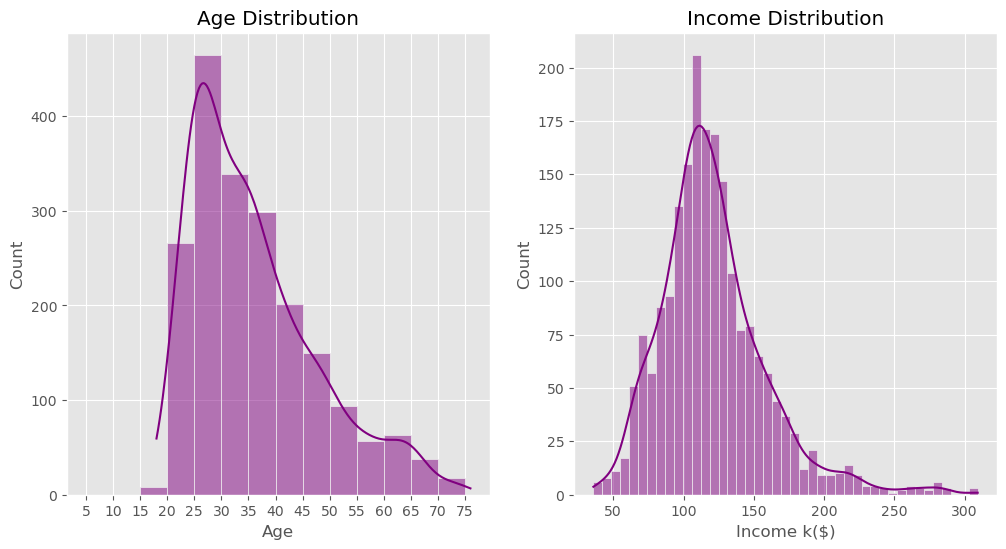

In [6]:
from matplotlib.ticker import MultipleLocator

fig = plt.figure(figsize=(12,6))

plt.subplot(121)
sns.histplot(data=data, x='Age', bins=np.arange(5,80,5),kde=True,color='purple')
plt.gca().xaxis.set_major_locator(MultipleLocator(5))
plt.title('Age Distribution')

plt.subplot(122)
sns.histplot(data=data, x=data['Income']/1e3,color='purple',kde=True,)
plt.xlabel('Income k($)')
plt.title('Income Distribution')

Most of the customers are between 20 to 40 years old, meanwhile the annual income is spread between 90-150 k($). Both of these distributions are right-skewed.

#### Countplots

Next, let's peek at the countplots of categorical features, which show the counts of observations in each categorical bin using bars.

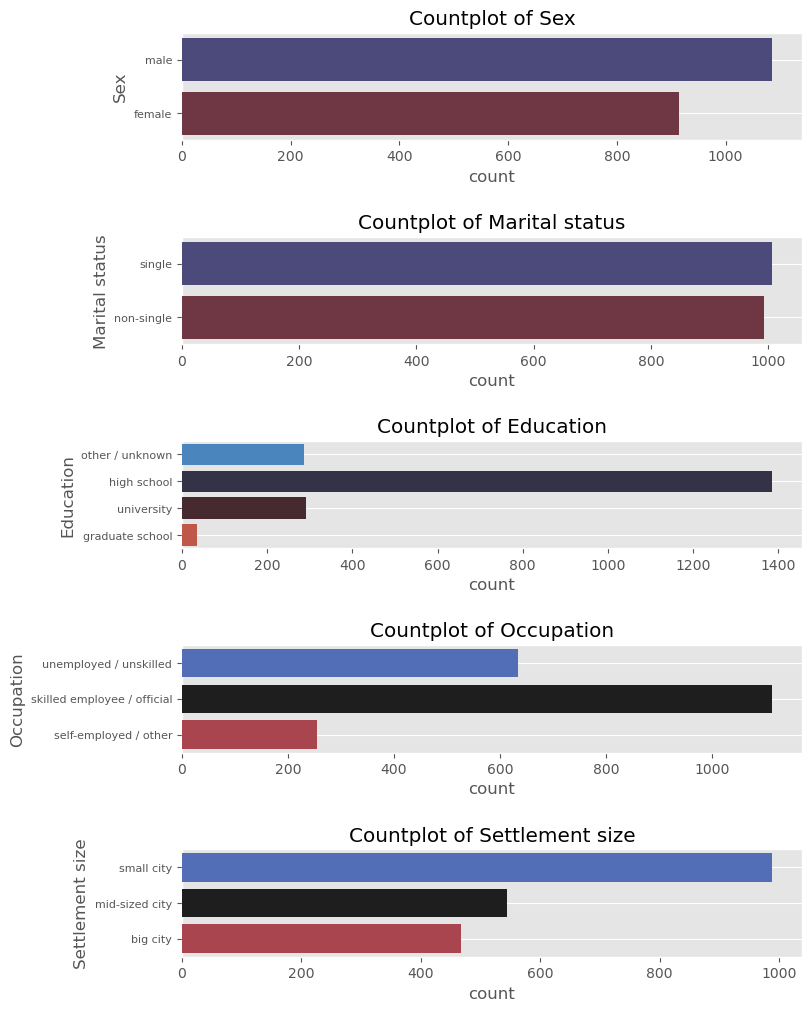

In [7]:
feature_labels = {
    'Sex':['male','female'], 
    'Marital status': ['single', 'non-single'],   
    'Education':['other / unknown','high school','university','graduate school'],
    'Occupation':['unemployed / unskilled', 'skilled employee / official', 'self-employed / other'],
    'Settlement size':['small city', 'mid-sized city', 'big city']
}

fig, ax = plt.subplots(5,1,figsize=(8,12))
plt.subplots_adjust(hspace=0.9, wspace=0.4)

for i, (feature, labels) in enumerate(feature_labels.items()):
    plt.subplot(5,1,i+1)
    sns.countplot(data=data, y=feature, palette='icefire', width=0.8, zorder=3,)
    plt.gca().set_yticklabels(labels, fontsize=8)  # subsitute the categorical values from dataset description.
    plt.grid()
    plt.title('Countplot of {}'.format(feature))

Let's now analyze each of the plot, from top to bottom.

*Sex*: This dataset contains the basic information about 2000 customers, and most of them are men, in particular around 1100 customers are males.

*Marital Status*: Non-single label here corresponds to divorced / separated / married / widowed. As we can see the number of single people and the number of non-single people is roughly the same.

*Education*: From the data in this dataset, we can deduce that the highest degree the majority of customers in this supermarket mall have is the high school diploma. Sometimes people with the first degree stop by, and more rarely do people with a higher degree. There is some number of people who either haven't mentioned their education level in the membership card or have written down other kind of educational attainment.

*Occupation*: The majority of our customers do have the job. Relating this information to education levels of customers we see that there is around 600 unemployed customers, which are supposedly the people who don't have a job at this very moment, high schoolers/students, elderly people or customers who just decided not to mention it. Also, there are around 200 customers whose occupations are some of these: management / self-employed / highly qualified employee / officer.

*Settlement size*: The half of the customers happen to live in small cities, while the rest are living in either mid-sized or big cities.

#### Scatterplots

Let's see what the relation between the Age and Income with respect to different categorical features reveals about the data.

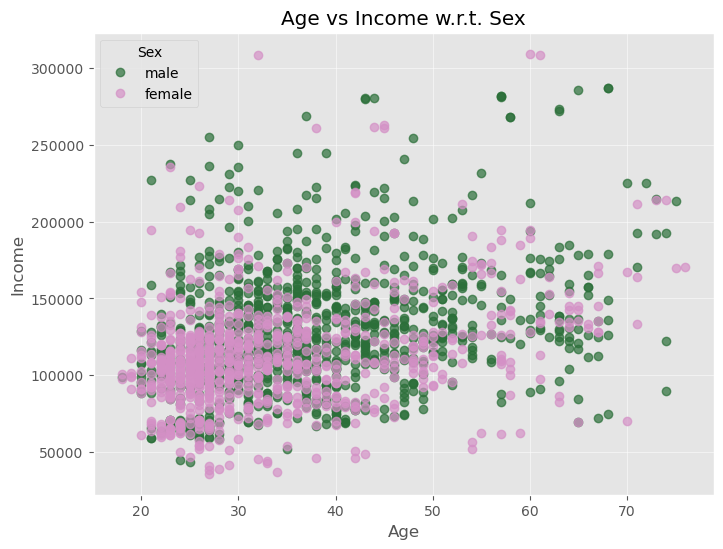

In [8]:
colored_scatterplot(data, x='Age', y='Income', hue='Sex', color_palette='cubehelix', alpha=0.7)

This plot doesn't seem to give us a lot to think about, except for the fact that the customers are usually women 20-45 y.o., or men 20-60 y.o.. Besides, the scatterplot shows that generally men tend to earn more than women.

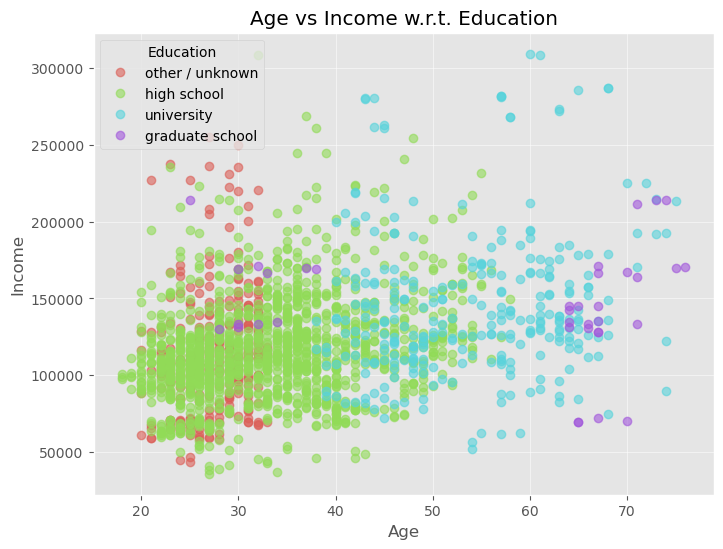

In [9]:
colored_scatterplot(data, x='Age', y='Income', hue='Education', color_palette='hls', alpha=0.6)

On the contrary, this one shows a lot of information.

First,it shows us that people who have an unknown educational degree are usually in their 20s or 30s, and have the median salary or lower than that. Next, the majority of customers who have the high school diploma at most are 20-55 years old, and have somewhat around a median annual income, or higher. 

Concerning the population who graduated from university with a bachelor's degree, they are usually 40-65 y.o. by now and have a slightly higher income than these with high school diploma solely. As for graduates, who are either young or over 60 y.o. by now, they too have a slightly higher income than the median income, but that can't be stated with certainty, because we don't have a lot customers with that kind of educational attainment.

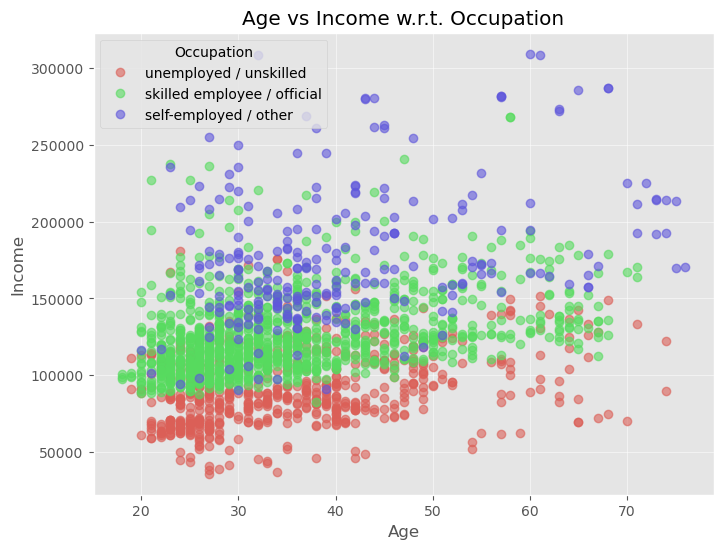

In [10]:
colored_scatterplot(data, x='Age', y='Income', hue='Occupation', color_palette='hls', alpha=0.6)

It's common sense to think that the more skilled the person is, the higher income they have. And this plot confirms it.

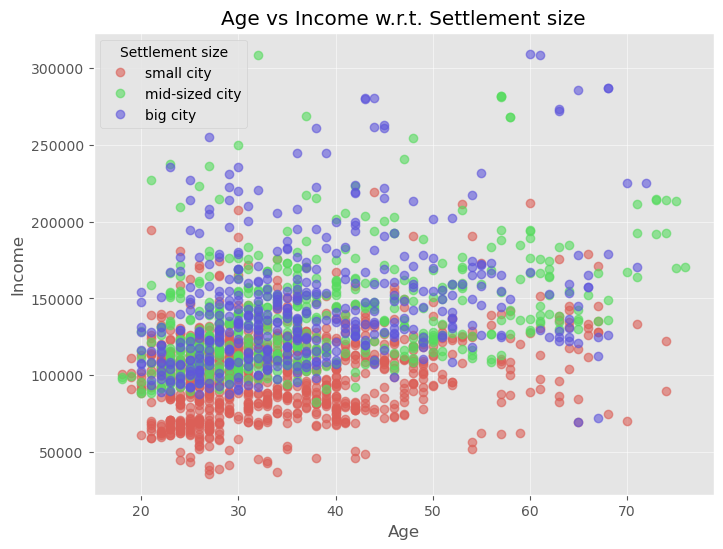

In [11]:
colored_scatterplot(data, x='Age', y='Income', hue='Settlement size', alpha=0.6)

The plot above shows that people living in small cities are usually paid less, meanwhile the annual salaries of these living in larger cities commonly range from 100 k(dollars) to 250 k(dollars).

<a id="dimred"></a>
## Dimensionality Reduction

Principal Component Analysis (PCA) is a useful tool for customer segmentation because it helps to identify the most important factors or variables that contribute to the differences between customers. By reducing the dimensionality of the data, PCA allows us to simplify the data and focus on the most important information, which can make it easier to interpret. 

Also, it is extremely useful for data visualization. Reducing the number of dimensions down to two (or three) makes it possible to plot a condensed view of a high-dimensional data on a graph and often gain some important insights by visually detecting patterns, such as clusters.

PCA is affected by scale, so we need to scale the features before applying PCA. We're going to use StandardScaler to standardize the dataset features onto unit scale (mean = 0 and standard deviation = 1) which is a requirement for the optimal performance of many Machine Learning algorithms.

In [12]:
from sklearn.preprocessing import StandardScaler

# Scaling the data
std = StandardScaler()
data_std = pd.DataFrame(std.fit_transform(data), columns=data.columns)

data_std.head()

ID       Sex  Marital status       Age  Education    Income  \
0 -1.731185 -0.917399       -0.993024  2.653614   1.604323  0.097524   
1 -1.729453  1.090038        1.007025 -1.187132  -0.063372  0.782654   
2 -1.727721 -0.917399       -0.993024  1.117316  -0.063372 -0.833202   
3 -1.725989 -0.917399       -0.993024  0.775916  -0.063372  1.328386   
4 -1.724257 -0.917399       -0.993024  1.458716  -0.063372  0.736932   

   Occupation  Settlement size  
0    0.296823         1.552326  
1    0.296823         1.552326  
2   -1.269525        -0.909730  
3    0.296823         0.321298  
4    0.296823         0.321298

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3, random_state=5)  # Reducing dimensions to 3.
data_reduced = pd.DataFrame(pca.fit_transform(data_std),)

data_reduced.head()

0         1         2
0  2.859782  0.936676  2.036586
1  0.944130  0.394492 -2.433785
2 -0.023032 -0.881797  1.974083
3  2.212422 -0.563616  0.635332
4  2.110202 -0.425124  1.127543

In [14]:
# Create a scatterplot.
trace = go.Scatter3d(x=data_reduced[0], y=data_reduced[1], z=data_reduced[2], mode='markers',
                     marker=dict(size=3 ,opacity=0.8, color='green'),)
    
layout = go.Layout(title=dict(text='The 3D Data', x=0.5), width=600, height=600)
fig = go.Figure(data=[trace], layout=layout)

fig.show()

<a id="clustering"></a>
## Clustering

Now that we have reduced the dimensions of our data, let's get down to clustering. We'll be exploring different techniques until the desired result is achieved.

<a id="kmeans"></a>
### **K-Means**

We'll start off with the K-Means algorithm, which is quick and efficient when it comes down to clustering.

Parameters: `n_clusters`

#### *Optimal number of clusters*

Let's try to find the optimal number of clusters using the 'elbow' method. In cluster analysis, the method consists of plotting the inertia as a function of the number of clusters and picking the elbow of the curve as the number of clusters to use.

Text(0, 0.5, 'Inertia')

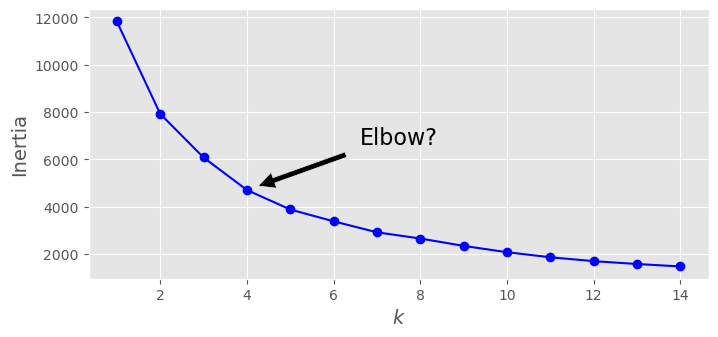

In [15]:
from sklearn.cluster import KMeans

kmeans_per_k = [KMeans(n_clusters=k).fit(data_reduced) for k in range(1,15)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(1,15), inertias, "bo-")

plt.annotate('Elbow?',xy=(4, inertias[3]), xytext=(0.45, 0.55), textcoords='figure fraction',
             fontsize=16, arrowprops=dict(facecolor='black', shrink=0.1))

plt.xlabel('$k$', fontsize=14)
plt.ylabel('Inertia', fontsize=14)

As you can see, we don't have a clear elbow, but let's assume it is somewhere around k=4. Picking the elbow means that taking less clusters will not give us any good clusters, and taking more clusters won't get us anywhere either. Still, let's take another approach before making up our mind about the number of clusters - the silhouette score plot. 

The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like the number of clusters visually. The silhouette coefficient can vary between -1 and +1: a coefficient close to +1 means that the instance is well inside its own cluster and far from other clusters, while a coefficient close to 0 means that it is close to a cluster boundary, and finally a coefficient close to -1 means that the instance may have been assigned to the wrong cluster.

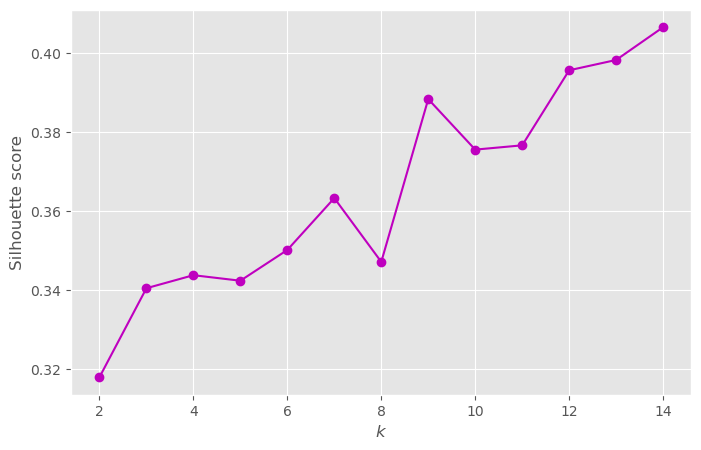

In [16]:
from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score(data_reduced, model.labels_) for model in kmeans_per_k[1:]]

plt.figure(figsize=(8,5))
plt.plot(range(2,15),silhouette_scores,'mo-')
plt.xlabel("$k$", )
plt.ylabel("Silhouette score", )
plt.grid(True)

Well, it's pretty obvious that as the number of clusters grows, each instance might find itself much closer to some cluster and so the silhouette score rises, compared to when the number of clusters was less. What we are looking for is the proof that the values around 3-6 can be used for `k`. 

Let's take a look at another diagram before making a decision. In this kind of plot every instance's silhouette coefficient is sorted by the cluster they are assigned to and by the value of the coefficient and then plotted.

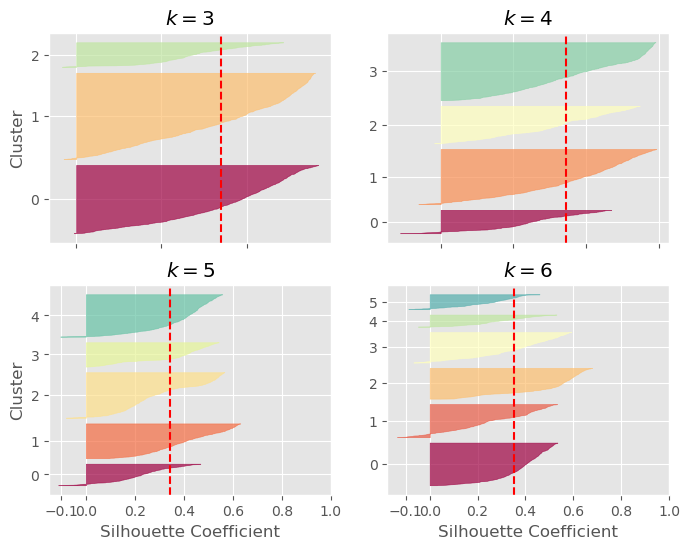

In [17]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(8,6))

for k in (3,4,5,6):
    plt.subplot(2,2,k-2)
    
    y_pred = kmeans_per_k[k-1].labels_
    silhouette_coeffs = silhouette_samples(data_reduced, y_pred)
    
    padding = len(data_reduced) // 30
    pos = padding
    ticks = []
    
    for i in range(k):
        coeffs = silhouette_coeffs[y_pred == i]   # cluster coeffs
        coeffs.sort()
        
        color = plt.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs, facecolor=color, 
                          edgecolor=color, alpha=0.7)
        
        ticks.append(pos + len(coeffs)//2)
        pos +=len(coeffs) + padding
        
    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    
    if k in (3,5):
        plt.ylabel("Cluster")
    if k in (5,6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)
    
    plt.axvline(x=silhouette_scores[k-2], color='red', linestyle='--')
    plt.title("$k={}$".format(k),)

As we can see, from this diagram it looks like k=5 might be the best option,as all clusters are roughly the same size and cross the dashed line which is the mean silhouette score.

So we will define `k=5`.

#### *Fitting KMeans with the best parameters*

Now, let's visualize these clusters to check how well the algorithm performed.

In [18]:
kmeans = KMeans(n_clusters=5, )
data['kmeans_cluster'] = kmeans.fit_predict(data_reduced) # Fit the model and predict clusters
data['kmeans_cluster'] = data['kmeans_cluster'].astype('category')

In [19]:
temp = data_reduced.copy()
cluster_col = 'kmeans_cluster'
temp[cluster_col] = data[cluster_col].copy()
temp.sort_values(by=cluster_col, inplace=True)

plot_clusters3d(cluster_groups=temp, cluster_col=cluster_col, colorscale='rainbow',
                title='The Plot of Clusters (KMeans)')

#### *The distribution of clusters*

In [20]:
sns.countplot(x=data['kmeans_cluster'], palette=sns.color_palette("pink"))
plt.title('Distribution of Clusters');

So, the number of instances in each cluster is very roughly the same, without large fluctuations and the algorithm seems to find the ways to split the data into, good or bad, clusters. 

Despite being fast and scalable, K-Means is not perfect. One of its disadvantages is the fact that it doesn't behave very well when the clusters have varying sizes, different densities, or **non-spherical shapes**. Let's experiment with other clustering algorithms to see the differences they make and pick the one that fits the data the best.

<a id="db"></a>
### **Density Based Clustering (DBSCAN)**

This algorithm defines clusters as continuous regions of high density. Thanks to this approach it can identify clusters of arbitrary shapes. The whole idea is of this algorithm is that if a particular point belongs to a cluster, it should be a neighbor to lots of other points in that cluster. This algorithm works well if all the clusters are dense enough, and they are well separated by low-density regions. Let's check it out.

We need to optimise two parameters: `eps` and `min_samples`.

#### *Optimal eps value and min_samples value*

`eps` is a value that deals with the radius of the clusters we are trying to find. To choose a value, we can perform a sort of elbowing technique (a similar technique that is often used to determine an optimal k in K-Means clustering), but this time using NearestNeighbors.

Then, to find the best combination of these two parameters, we'll search for the highest silhoutte score.

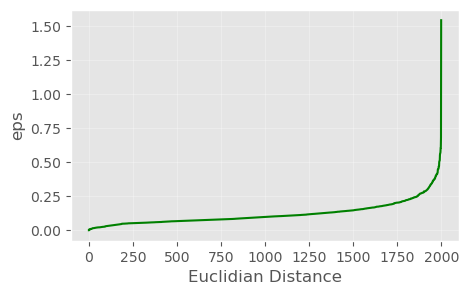

In [21]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

nn = NearestNeighbors(n_neighbors=10).fit(data_reduced)

# Calculate the average distance between each point and its k-nearest neighbors
distances, indices = nn.kneighbors(data_reduced)

# Plot number of points vs average distance. Find the elbow (eps is the y-value)
distances = np.sort(distances, axis=0)
distances = distances[:, 1]   

plt.figure(figsize=(5,3))
plt.plot(distances, c='green', )
plt.xlabel('Euclidian Distance')
plt.ylabel('eps')
plt.grid(alpha=0.3)

By changing around the number of neighbors, we finally came to the conclusion and defined the approximate ranges for parameters. Let's assume that `eps` ranges from 0.2 to 0.8 and `min_sample` from 5 to 25. 

Now, our final choice of parameters will be decided by the best silhouette score DBSCAN gives depending on the ranges of parameters we have. Let's calculate it.

In [22]:
db_silhouette_scores = []
params = [(ms, eps.round(3)) for ms in range(5,25) for eps in np.arange(0.2, 0.8, step=0.1)]
    
for ms, eps in params:  
    pred_labels = DBSCAN(eps=eps, min_samples=ms).fit(data_reduced).labels_
    db_silhouette_scores.append(silhouette_score(data_reduced, pred_labels))

In [23]:
idx_best = np.argmax(db_silhouette_scores)   # index of the highest score
print("Best silhouette score {} for (min_samples={}, eps={})" \
      .format(db_silhouette_scores[idx_best].round(4),params[idx_best][0], params[idx_best][1]))

Best silhouette score 0.2753 for (min_samples=22, eps=0.7)


#### *Fitting DBSCAN with the best parameters*

In [24]:
dbscan = DBSCAN(eps=0.7, min_samples=22).fit(data_reduced)
pred_labels = dbscan.labels_
data['db_cluster'] = dbscan.labels_
data['db_cluster'] = data['db_cluster'].astype('category')

print(f"Number of clusters: {len(np.unique(pred_labels))} \
      \nNumber of outliers: {len(pred_labels[pred_labels==-1])}")

Number of clusters: 6       
Number of outliers: 178


In [25]:
temp = data_reduced.copy()
cluster_col = "db_cluster"
temp[cluster_col] = data[cluster_col].copy()
temp.sort_values(by=cluster_col, inplace=True)

plot_clusters3d(cluster_groups=temp, cluster_col=cluster_col, colorscale='rainbow',
                title='The Plot of Clusters (DBSCAN)')

#### *The distribution of clusters*

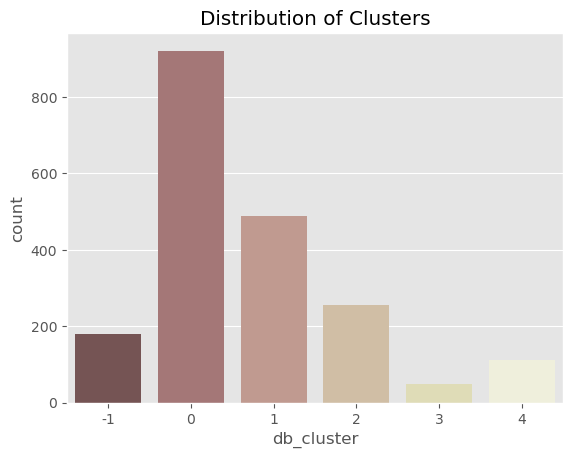

In [26]:
sns.countplot(x=data['db_cluster'], palette=sns.color_palette("pink"))
plt.title('Distribution of Clusters');

Now, the DBSCAN algorithm has managed to distinguish different ellipsoidal groups of points, as can be seen in the 3D plot. These clusters do have varying densities, so it's no wonder that the blue cluster has almost a half of all data points, whilst all other clusters have much less.

Let's continue to check other algorithms and we might come across an algorithm that will be able to distinguish each visible cluster in the 3D plot, so that we can later compare these different clusters computed by different algorithms and decide which one fits the data the best.

<a id="gm"></a>
### **Gaussian Mixtures**

A Gaussian mixture model (GMM) is a probabilistic model that assumes that the
instances were generated from a mixture of several Gaussian distributions whose
parameters are unknown. All the instances generated from a single Gaussian distribution
form a cluster that typically looks like an ellipsoid. Each cluster can have a different
ellipsoidal shape, size, density and orientation.

Parameters to optimize: `n_components`, `covariance_type`

#### *Selecting the optimal number of components (clusters)*

With K-Means, you could use the inertia or the silhouette score to select the appropriate number of clusters, but with Gaussian mixtures, it is not possible to use these metrics because they are not reliable when the clusters are not spherical or have different sizes. Instead, you can try to find the model that minimizes a theoretical information criterion such as the Bayesian information criterion (BIC) or the Akaike information criterion (AIC).

Next, we'll plot both AIC and BIC for different numbers of clusters. Also, we'll try limiting the range of shapes and orientations the clusters can have by imposing constraints on the covariance matrices. There are a few possible values for `covariance_type` parameter:
* "spherical": all clusters must be spherical, but can have different diameters
* "diag": clusters can take on any ellipsoidal shape of any size.
* "tied": all clusters must have the same ellipsoidal shape, size and orientation.
* "full" (default): each cluster can take on any shape, size and orientation.

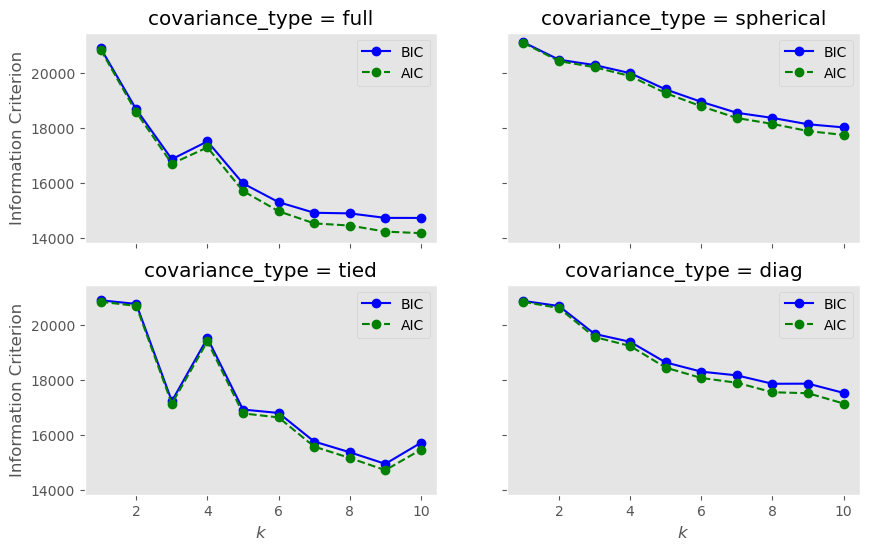

In [27]:
from sklearn.mixture import GaussianMixture

fig, axs = plt.subplots(2,2,figsize=(10,6), sharex=True, sharey=True)

for i, cov in enumerate(['full','spherical', 'tied', 'diag']):
    gms_per_k = [GaussianMixture(n_components=k, n_init=10, covariance_type=cov)\
                 .fit(data_reduced) for k in range(1,11)]
    bics = [model.bic(data_reduced) for model in gms_per_k]
    aics = [model.aic(data_reduced) for model in gms_per_k]
    
    plt.subplot(2,2,i+1)
    plt.plot(range(1,11), bics, "bo-", label="BIC")
    plt.plot(range(1,11), aics, "go--", label="AIC")
    
    plt.title("covariance_type = {}".format(cov))
    plt.xlabel('$k$') if i in(2,3) else plt.xlabel('')
    plt.ylabel('Information Criterion') if i in(0,2) else plt.ylabel('')
    plt.grid()
    plt.legend()

Let's search for best combination of values for both the number of clusters and the `covariance_type` hyperparameter:

In [28]:
min_bic = np.infty

for k in range(1,11):
    for cov in ("full", "tied", "spherical", "diag"):
        bic = GaussianMixture(n_components=k, n_init=10, covariance_type=cov)\
                             .fit(data_reduced).bic(data_reduced)
        if bic < min_bic:
            min_bic = bic
            best_k = k
            best_covariance_type = cov
            
best_k, best_covariance_type

(10, 'full')

So we can see it is either 'tied' or 'full' that gives us the lowest IC. Well, by taking a look at the 3D plots so far, we can surely say that our data **does** have a somewhat ellipsoidal shape, so the GaussianMixtures algorithm guessed that right. The other issue that arises is that it's now up to us to decide how to treat the data that doesn't have ellipsoidal shape. Should we take it into account and treat it as separate clusters or just add them to the big clusters present? 

Personally, I'll go with the second option due to the "outlier" data having a low density, i.e. there are not enough data points to form distinct clusters, as it's scattered all over the 3D space. So from the graphs above, I'll be pretty much satisfied with parameters `covariance_type="tied"` and `k=7`.

In [29]:
# from sklearn.mixture import BayesianGaussianMixture

# bgm = BayesianGaussianMixture(n_components=7, n_init=10, covariance_type="tied")
# bgm_labels = bgm.fit_predict(data_reduced)

# np.round(bgm.weights_, 2)

#### *Fitting GaussianMixture with the best parameters*

In [30]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=7, n_init=10, covariance_type='tied',random_state=5)
data['gm_cluster'] = gm.fit_predict(data_reduced)
data['gm_cluster'] = data['gm_cluster'].astype('category')

In [31]:
temp = data_reduced.copy()
cluster_col = "gm_cluster"
temp[cluster_col] = data[cluster_col].copy()
temp.sort_values(by=cluster_col, inplace=True)

plot_clusters3d(cluster_groups=temp, cluster_col=cluster_col, colorscale='rainbow',
                title='The Plot of Clusters (GaussianMixture)')

#### *The Distribution of Clusters*

Text(0.5, 1.0, 'Distribution of Clusters')

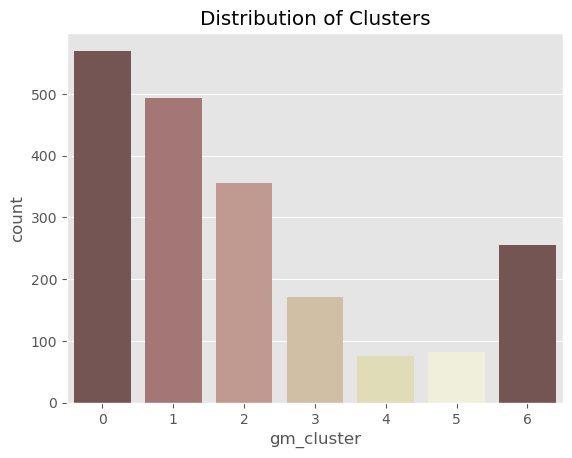

In [32]:
sns.countplot(x=data['gm_cluster'], palette=sns.color_palette("pink"))
plt.title('Distribution of Clusters')

While gaussian mixture models are able to handle clusters of varying shapes and sizes, they do make some assumptions about the shape of the clusters. Specifically, the clusters are assumed to be elliptic. This means that gaussian mixture models will not perform as well in cases where clusters are very irregularly shaped. Fortunately, we don't get to deal with that.

One of the drawbacks of GMs is that they ordinarily can be thrown off by cases where there are many outliers in the data. Also, there are lot parameters to fit, and usually the GM models require lots of data and many iterations to get good results.

Nonetheless, the result looks fairly good, because the algorithm recognized the ellipsoidal clusters. We'll check later on whether it's the right approach.

<a id="agg"></a>
### **Agglomerative clustering**

Hierarchical clustering is a general family of clustering algorithms that build nested clusters by merging or splitting them successively. This hierarchy of clusters is represented as a tree (or dendrogram). The root of the tree is the unique cluster that gathers all the samples, the leaves being the clusters with only one sample. The AgglomerativeClustering object performs a hierarchical clustering using a bottom up approach: each observation starts in its own cluster, and clusters are successively merged together. 

It has the following parameters that we will be interested in: `linkage`, `n_clusters`

#### *Choosing optimal number of clusters*

To get the optimal number of clusters for hierarchical clustering, we make use a *dendrogram* which is tree-like chart that shows the sequences of merges or splits of clusters. If two clusters are merged, the dendrogram will join them in a graph and the height of the join will be the distance between those clusters.

We can play around with `linkage` parameter, however, we'll go with the value 'complete' as we think it seems to describe the data the best.

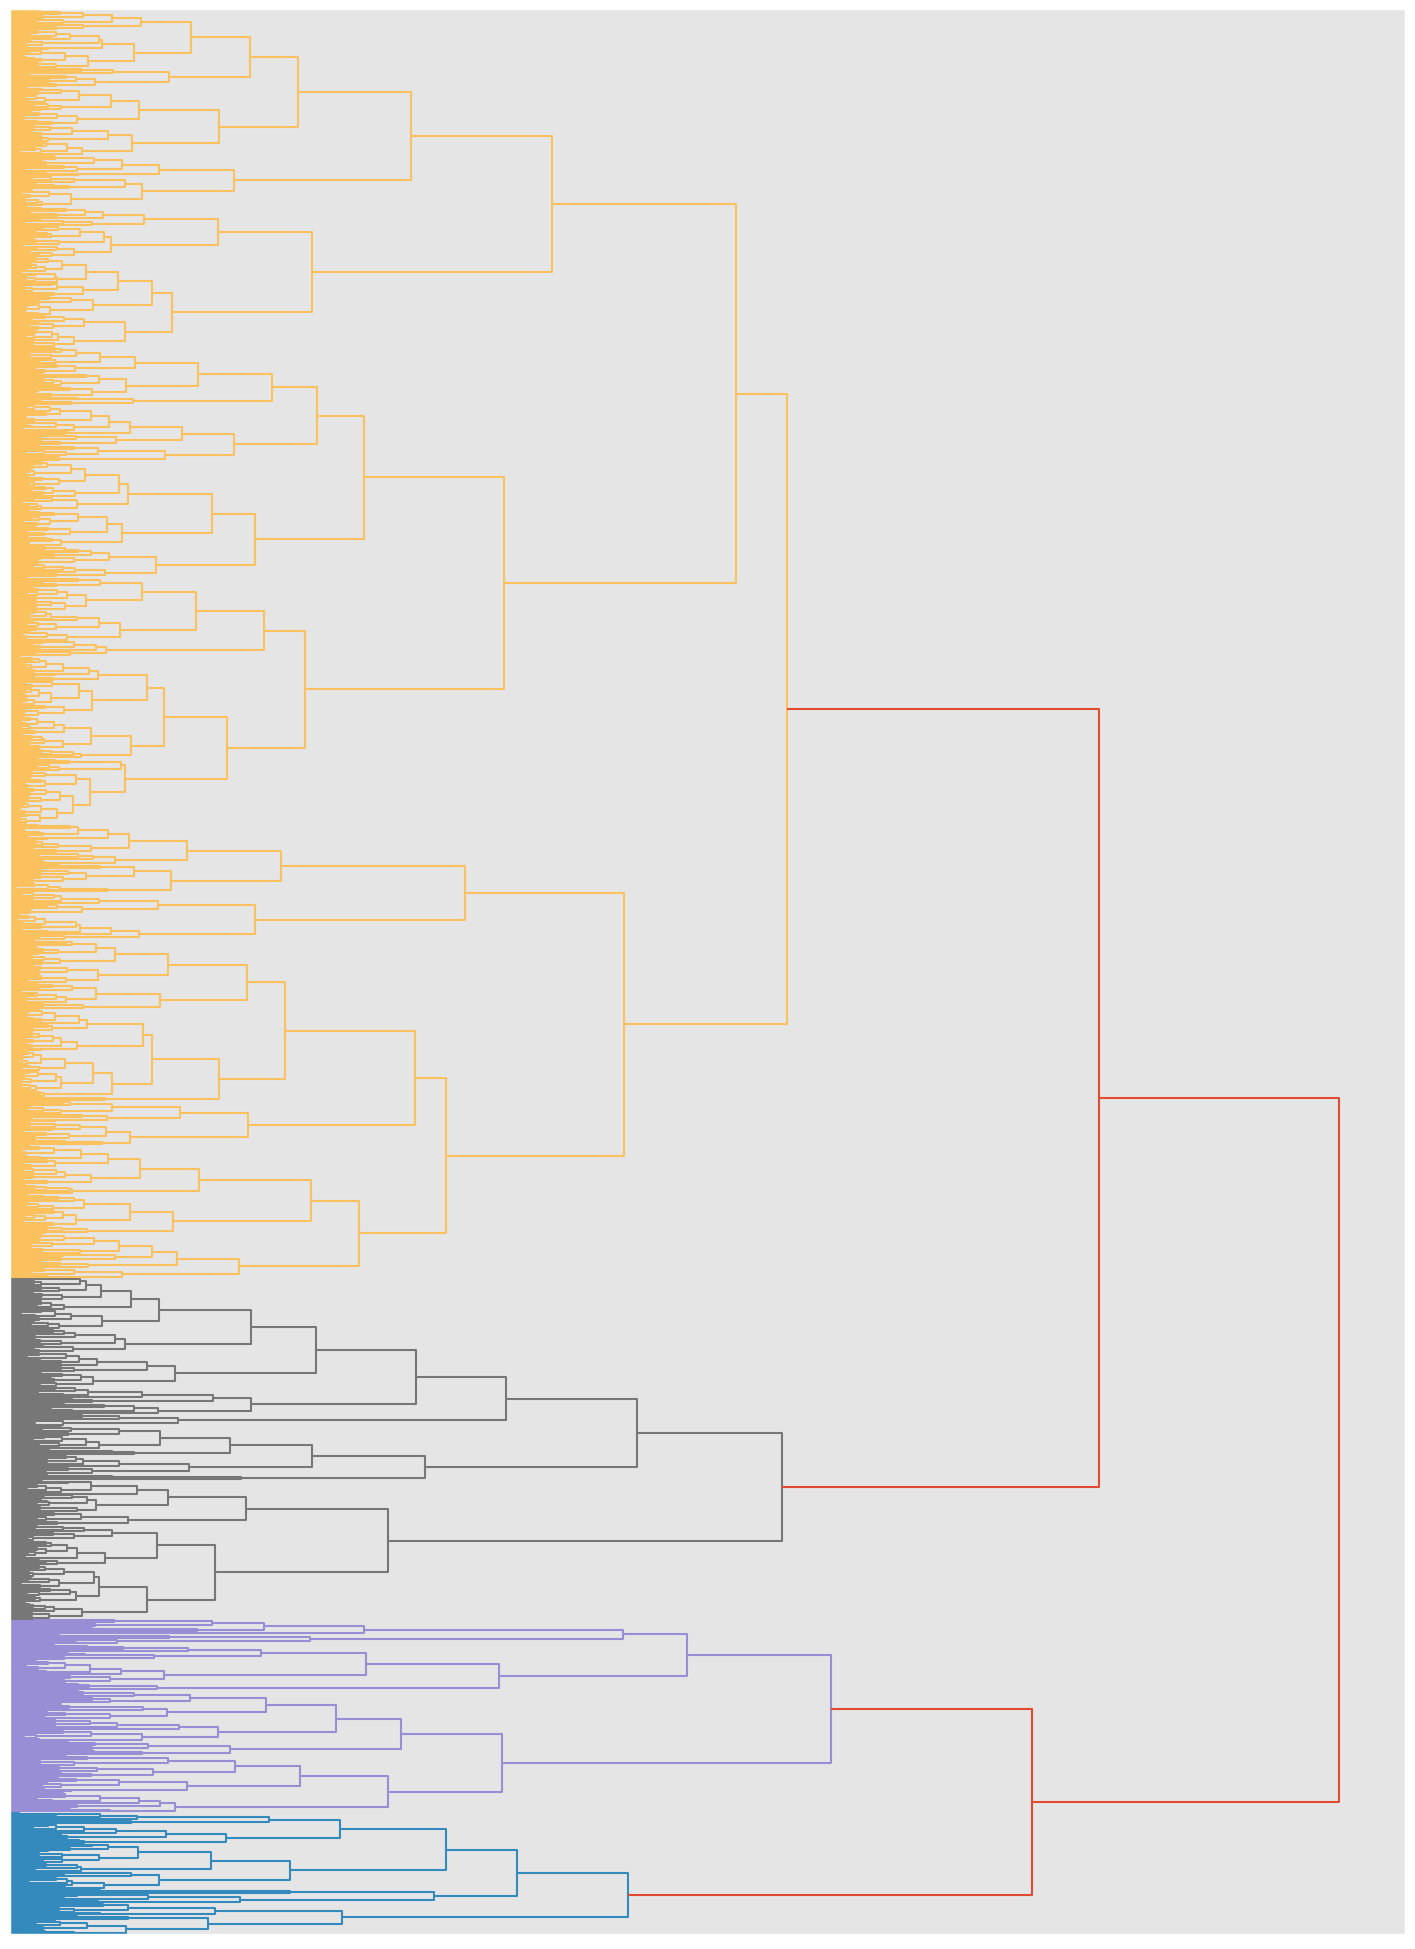

In [33]:
# Dendogram for Heirarchial Clustering
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(18,25))
dend = shc.dendrogram(shc.linkage(data_reduced, method='complete'),orientation='right')

plt.yticks([])
plt.xticks([])
plt.show()

We can choose the optimal number of clusters based on hierarchical structure of the dendrogram. As highlighted by other cluster validation metrics, 5 clusters can be considered good for the agglomerative hierarchical as well.

#### *Fitting the AgglomerativeClustering* with the best parameters

In [34]:
from sklearn.cluster import AgglomerativeClustering

agglom = AgglomerativeClustering(n_clusters=5, linkage='complete', )
data['agg_cluster'] = agglom.fit_predict(data_reduced)
data['agg_cluster'] = data['agg_cluster'].astype('category')

In [35]:
temp = data_reduced.copy()
cluster_col = "agg_cluster"
temp[cluster_col] = data[cluster_col].copy()
temp.sort_values(by=cluster_col, inplace=True)

plot_clusters3d(cluster_groups=temp, cluster_col=cluster_col, colorscale='rainbow',
                title='The Plot of Clusters (AgglomerativeClustering)')

#### *The Distribution of Clusters*

Text(0.5, 1.0, 'Distribution of Clusters')

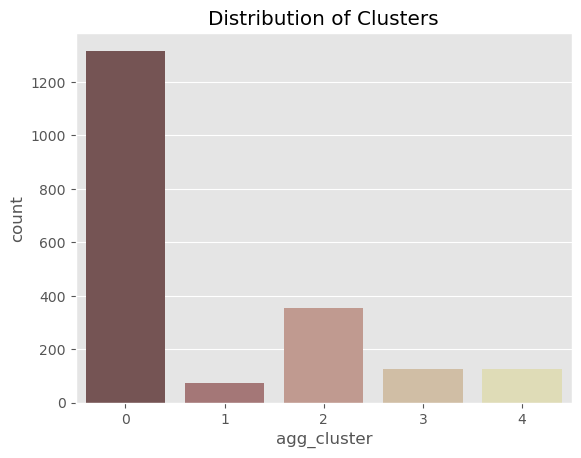

In [36]:
%matplotlib inline

sns.countplot(x=data['agg_cluster'], palette=sns.color_palette("pink"))
plt.title('Distribution of Clusters')

As we can see, AgglomerativeClustering doesn't do a good job at identifying ellipsoidal clusters, even though we have already pushed it to its limits, and got us one huge cluster,leaving the rest clusters with around 200 data points, 

Other algorithms you might find interesting:
* Spectral Clustering
* OPTICS
* Fast-MCD (EllipticEnvelope) and more..

<a id="compare"></a>
## Clustering Comparison

So far, we have tested out 4 different aprroaches to doing clustering. It will be fair enough to finally compare them and choose the one that is the best fit for our data before moving on to customer profiling.
In the figure below are shown the results of clustering done by each clustering algorithm. 

![Clustering Algorithms (plotted using mpl_toolkits)](https://i.ibb.co/PYWJwqr/Clusters.png)

Generally speaking, each of the algorithms mentioned predicted that the data can be assigned to from 5 to 7 clusters. That sounds good, because it confirms that this is the right range for an optimal number of clusters no matter which algorithm for clustering we use.

Now, if we were to take a look at each of these plots in the figure above, we may conclude that before deciding on which algorithm performed the best we have to make some assumptions about the shape of our data first. That will define which kind of clusters we would expect for it. So far I have come to the conclusion that the best way to describe our 3-dimensional data points is to replace the high-density groups of these points with ellipsoids. 

If we continue to stick with our assumption, then we can clearly see that both the Kmeans algorithm and the AgglomerativeClustering algorithm could not identify these clusters quite precisely as Gaussian Mixtures and DBSCAN did. They've been casually splitting these long groups of data points in a half or around that, and have been considering these parts some distance away from each other a cluster. Sometimes they happen to guess the clusters, but most of the time they fail to.

Concerning the algorithms that were able to identify the whole clusters, we may need to settle whether we want the 'noisy' data (or the data points named outliers (-1) in DBSCAN plot) to be their own cluster of underrepresented types of customers, or we would just add it to the large clusters that already exist. Both algorithms perform well, so that's the only reasoning behind our decision.

In my opinion, it will be wise to choose the Gaussian Mixture model in this case, because it perfectly captures the visible clusters in the plot.

<a id="profile"></a>
## Customer Profiling

 Let's now see what these clusters tell us about customers who belong to them. For that, we will take a look at the data in the light of clusters using visualization tools and then will try to figure out the nature of the clusters formed.

#### **Cluster's Profile Based on Education**

In [37]:
group = data[['ID','Education', 'gm_cluster']].sort_values(by='gm_cluster')
education_per_cluster = group.groupby(['gm_cluster','Education']).count()

ax = education_per_cluster.unstack().plot(kind='bar', stacked=True, cmap=plt.cm.plasma,
                                         xlabel='Cluster', ylabel='Count', figsize=(8,8))

# Add labels to the bar chart.
for c in ax.containers:
    # if the segment is small or 0, skip it
    labels = [int(v.get_height()) if v.get_height() > 0 else '' for v in c]
    
    ax.bar_label(c, labels=labels, label_type='center', fontstyle='oblique', 
                 fontvariant='small-caps', bbox=dict(facecolor='white',alpha=0.5,pad=1.6))
    
# Substituting the dummies for education with categorical values from the dataset description.
plt.legend(feature_labels.get('Education'), loc='upper left', title='Education', frameon=True)
plt.xticks(rotation=0)
plt.title('Education Distribution in each Cluster')

Text(0.5, 1.0, 'Education Distribution in each Cluster')


#### **Customer's Profile based on Sex**

In [38]:
group = data[['ID','Sex', 'gm_cluster']].sort_values(by='gm_cluster')
sex_per_cluster = group.groupby(['gm_cluster','Sex']).count()

ax = sex_per_cluster.unstack().plot(kind='bar', xlabel='Cluster', ylabel='Count', figsize=(6,6),
                                    cmap=plt.cm.seismic, width=0.8)

# Substituting the dummies for education with categorical values from the dataset description.
plt.legend(["male", "female"], loc='upper left', title='Sex', frameon=True)
plt.xticks(rotation=0)
plt.title('Sex Distribution in each Cluster')
plt.show();

#### **Customer's Profile based on Age**

To make a "bar of pie" we used this [code](https://matplotlib.org/stable/gallery/pie_and_polar_charts/bar_of_pie.html#sphx-glr-gallery-pie-and-polar-charts-bar-of-pie-py). This code makes a "bar of pie" chart where the first slice of the pie is "exploded" into a bar chart with a further breakdown of said slice's characteristics.


In [39]:
from matplotlib.patches import ConnectionPatch
from matplotlib import patheffects

def bar_of_pie_chart(cluster_members, age_per_cluster, cluster_number):
    # make figure and assign axis objects
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
    fig.subplots_adjust(wspace=0)

    # pie chart parameters
    overall_ratios = cluster_members.percent.values
    labels = cluster_members.index
    explode = [0]*len(labels)
    explode[cluster_number] = 0.1
    
    # rotate so that the wedge is split by the x-axis
    angle = -180*overall_ratios[0]
    if cluster_number > 0:
        angle -=52 * cluster_number
    
    wedges, *_ = ax1.pie(overall_ratios, autopct='%1.1f%%', startangle=angle,
                         labels=labels, explode=explode)

    # bar chart parameters
    age_ratios = age_per_cluster.percent.loc[cluster_number].values
    age_labels = age_per_cluster.percent.loc[cluster_number].index.values
    bottom = 1
    width = .2

    # Adding from the top matches the legend.
    for j, (height, label) in enumerate(reversed([*zip(age_ratios, age_labels)])):
        if height == 0:   # don't show the label in legend and values on the bar if there are no people in this age group.
            continue
        bottom -= height
        bc = ax2.bar(0, height, width, bottom=bottom, color='b', label=label,
                     alpha= 0.15 + 0.15 * j)
        ax2.bar_label(bc, labels=[f"{height:.0%}"], label_type='center', color='black', 
                      fontweight='black',)

    ax2.set_title('Age of customers')
    ax2.legend()
    ax2.axis('off')
    ax2.set_xlim(- 2.5 * width, 2.5 * width)

    # use ConnectionPatch to draw lines between the two plots
    theta1, theta2 = wedges[cluster_number].theta1, wedges[cluster_number].theta2
    center, r = wedges[cluster_number].center, wedges[cluster_number].r
    bar_height = sum(age_ratios)

    # draw top connecting line
    x = r * np.cos(np.pi / 180 * theta2) + center[0]
    y = r * np.sin(np.pi / 180 * theta2) + center[1]
    con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData,
                          xyB=(x, y), coordsB=ax1.transData)
    con.set_color([0, 0, 0])
    con.set_linewidth(2)
    ax2.add_artist(con)

    # draw bottom connecting line
    x = r * np.cos(np.pi / 180 * theta1) + center[0]
    y = r * np.sin(np.pi / 180 * theta1) + center[1]
    con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
                          xyB=(x, y), coordsB=ax1.transData)
    con.set_color([0, 0, 0])
    ax2.add_artist(con)
    con.set_linewidth(2)

In [40]:
group = data[['ID','Age', 'gm_cluster']].sort_values(by='gm_cluster')

# Group Age feature into a few categories, by looking at the distrib plot
max_age = group['Age'].max()
group['Age'].replace(range(15,25), "Under 25", inplace=True)
group['Age'].replace(range(25,35), "25-34", inplace=True)
group['Age'].replace(range(35,45), "35-44", inplace=True)
group['Age'].replace(range(45,61), "45-60", inplace=True)
group['Age'].replace(range(61, max_age+1), "Over 60", inplace=True)

# Cluster & Age count and percents
age_per_cluster = group.groupby(['gm_cluster','Age']).count()
age_per_cluster.rename(columns={'ID':'count'}, inplace=True)
age_per_cluster['percent'] = age_per_cluster.groupby(level=0).transform(lambda x: (x / x.sum()).round(2))

# Cluster count and percents
cluster_members = data[['gm_cluster','ID']].groupby(['gm_cluster']).count()
cluster_members.rename(columns={'ID':'count'}, inplace=True)
cluster_members['percent'] = cluster_members['count'] / cluster_members['count'].sum()

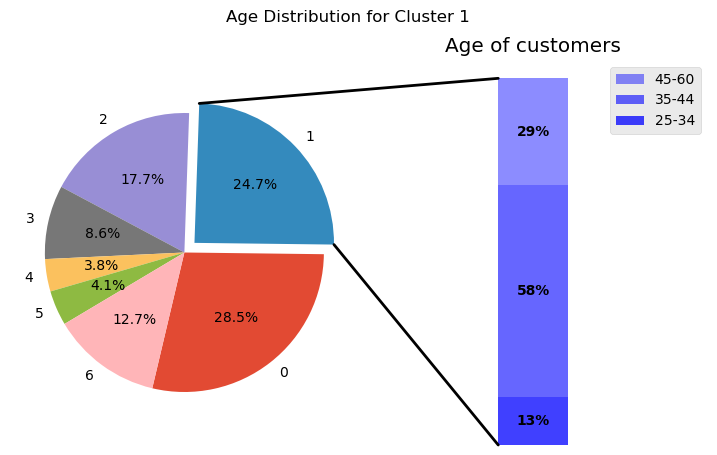

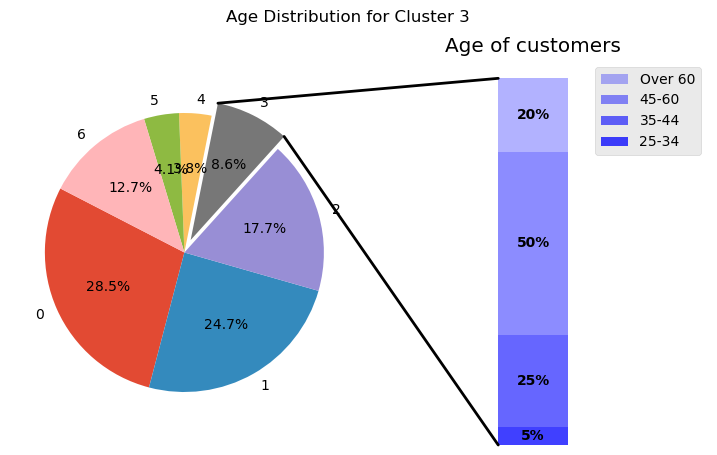

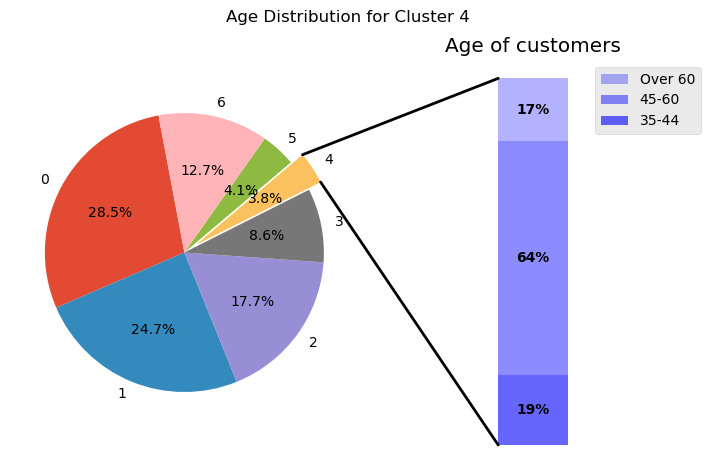

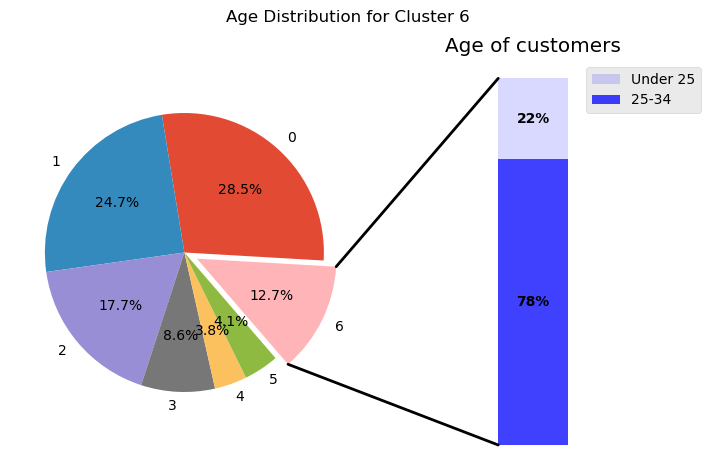

In [41]:
# for each cluster let's see what age groups it consists of
for k in range(7):
    bar_of_pie_chart(cluster_members, age_per_cluster, cluster_number=k)
    plt.suptitle("Age Distribution for Cluster {}".format(k))

#### **Cluster's Profile Based on Marital status**

Text(0.5, 1.0, 'Marital status Distribution in each Cluster')

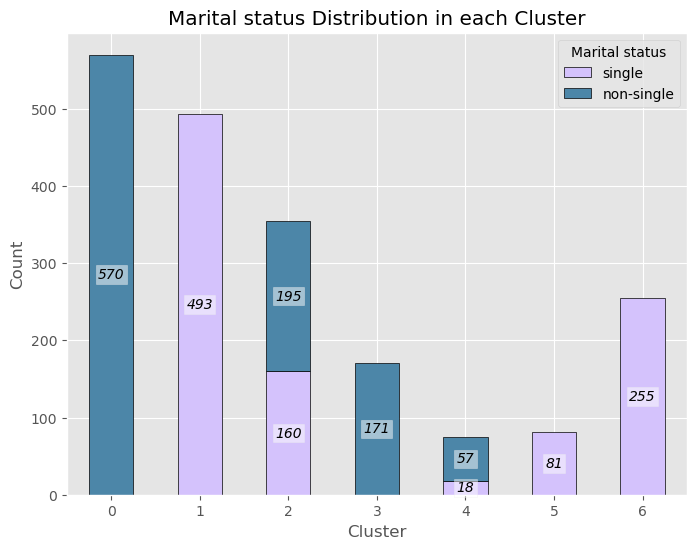

In [42]:
group = data[['ID','Marital status', 'gm_cluster']].sort_values(by='gm_cluster')
status_per_cluster = group.groupby(['gm_cluster','Marital status']).count()

colors = ['#D4C2FC','#4C86A8']
ax = status_per_cluster.unstack().plot(kind='bar', stacked=True, color=colors,edgecolor='black',
                                        xlabel='Cluster', ylabel='Count', figsize=(8,6))

# Add labels to the bar chart.
for c in ax.containers:
    # if the segment is small or 0, skip it
    labels = [int(v.get_height()) if v.get_height() > 0 else '' for v in c]
    
    ax.bar_label(c, labels=labels, label_type='center', fontstyle='oblique', 
                 fontvariant='small-caps', bbox=dict(facecolor='white',alpha=0.5,pad=1.6))
    
# Substituting the dummies for education with categorical values from the dataset description.
plt.legend(feature_labels.get('Marital status'), loc='upper right', title='Marital status', frameon=True)
plt.xticks(rotation=0)
plt.title('Marital status Distribution in each Cluster')

#### **Cluster's Profile Based on Occupation**

Text(0.5, 1.0, 'Occupation Distribution in each Cluster')

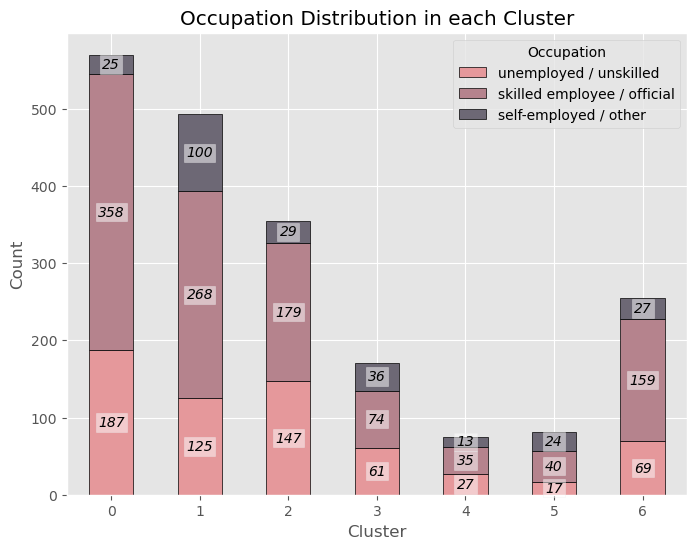

In [43]:
group = data[['ID','Occupation', 'gm_cluster']].sort_values(by='gm_cluster')
occupation_per_cluster = group.groupby(['gm_cluster','Occupation']).count()

colors = ['#E5989B','#B5838D','#6D6875']
ax = occupation_per_cluster.unstack().plot(kind='bar', stacked=True, color=colors,edgecolor='black',
                                         xlabel='Cluster', ylabel='Count', figsize=(8,6))

# Add labels to the bar chart.
for c in ax.containers:
    # if the segment is small or 0, skip it
    labels = [int(v.get_height()) if v.get_height() > 0 else '' for v in c]
    
    ax.bar_label(c, labels=labels, label_type='center', fontstyle='oblique', 
                 fontvariant='small-caps', bbox=dict(facecolor='white',alpha=0.5,pad=1.6))
    
# Substituting the dummies for education with categorical values from the dataset description.
plt.legend(feature_labels.get('Occupation'), loc='upper right', title='Occupation', frameon=True)
plt.xticks(rotation=0)
plt.title('Occupation Distribution in each Cluster')

#### **Cluster's Profile Based on Settlement size**

Text(0.5, 1.0, 'Settlement size Distribution in each Cluster')

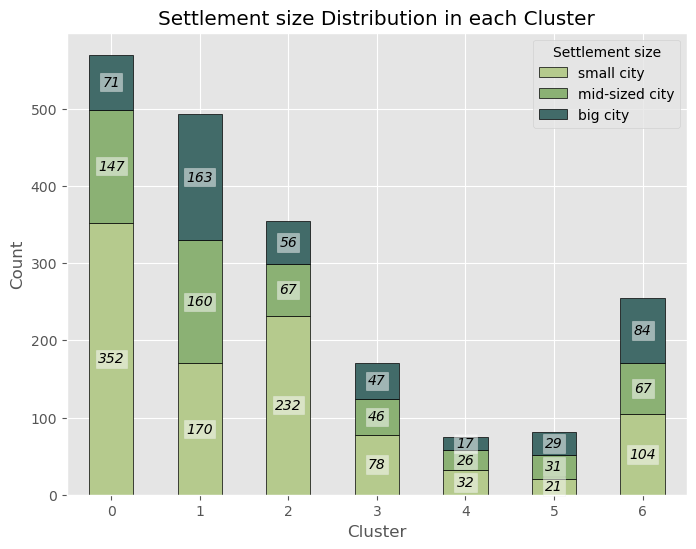

In [44]:
group = data[['ID','Settlement size', 'gm_cluster']].sort_values(by='gm_cluster')
occupation_per_cluster = group.groupby(['gm_cluster','Settlement size']).count()


colors = ['#B5CA8D','#8BB174','#426B69']
ax = occupation_per_cluster.unstack().plot(kind='bar', stacked=True, color=colors,edgecolor='black',
                                         xlabel='Cluster', ylabel='Count', figsize=(8,6))


# Add labels to the bar chart.
for c in ax.containers:
    # if the segment is small or 0, skip it
    labels = [int(v.get_height()) if v.get_height() > 0 else '' for v in c]
    
    ax.bar_label(c, labels=labels, label_type='center', fontstyle='oblique', 
                 fontvariant='small-caps', bbox=dict(facecolor='white',alpha=0.5,pad=1.6))
    
# Substituting the dummies for education with categorical values from the dataset description.
plt.legend(feature_labels.get('Settlement size'), loc='upper right', title='Settlement size', frameon=True)
plt.xticks(rotation=0)
plt.title('Settlement size Distribution in each Cluster')

#### **Cluster's Profile Based on Income**

In [45]:
group = data[['Income','gm_cluster']].sort_values(by='gm_cluster')
income_clusters = group.groupby('gm_cluster').agg(['mean','median'])
income_clusters.columns=['mean', 'median']

income_clusters.plot(kind='bar', color=["#65002E","#BD8798"], xlabel='Cluster', 
                     ylabel='Income', title="Cluster Income", width=0.7, edgecolor='black',)

<AxesSubplot:title={'center':'Cluster Income'}, xlabel='Cluster', ylabel='Income'>

The differences between mean and median are pretty visible, so we'll use the median as a measure of income for each cluster.

In [46]:
income_clusters

mean    median
gm_cluster                         
0           109528.475439  107408.5
1           129712.182556  124805.0
2           105919.676056  105230.0
3           141064.081871  135070.0
4           141270.493333  135332.0
5           159029.086420  136812.0
6           118938.882353  114584.0

<a id="summary"></a>
## Summary of Clusters' features

***
#### **Cluster 0**
***
<u>Sex:</u>  female

<u>Marital status:</u> non-single

<u>Age:</u> Under 25 (28%) / 25-34 (60%) / 35-44 (12%)

<u>Education:</u> high school

<u>Income:</u> 107 k($)

<u>Occupation:</u> mostly skilled employee, sometimes unemployed, very rarely self-employed

<u>Settlement size:</u> small city, rarely mid-sized city and even less common big city.

<u>Description</u>:

Cluster 0 is characterized by customers who are non-single females in their 20s (averagely 27 years old) with the high school diploma. For the most part, they are employed, albeit sometimes are not. Basically, they live in small towns and earn slightly lower than the median salary.

***
#### **Cluster 1**
***
<u>Sex</u>: male

<u>Marital status:</u> single

<u>Age:</u> 25-34 (13%) / 35-44 (58%) / 45-60 (29%)

<u>Education:</u> high school

<u>Income:</u> 125 k($)

<u>Occupation:</u> mostly skilled employee,sometimes unemployed or self-employed 

<u>Settlement size:</u> any kind of city.

<u>Description</u>:

Cluster 1 is characterized by customers who are single males with an average age of 40. They have never attended a university, but do mostly have a job, but not necessarily. They come from different kinds of settlements, and have a slightly higher income, compared to the median income.

***
#### **Cluster 2**
***
<u>Sex:</u>  male or female

<u>Marital status:</u>  either single or non-single

<u>Age:</u> Under 25 (17%) / 25-34 (54%) / 35-44 (25%) / 45-60 (5%)

<u>Education:</u> high school, pretty rarely unknown

<u>Income:</u> 105 k($)

<u>Occupation:</u> either skilled employee or unemployed, rarely self-employed

<u>Settlement size:</u> small city, rarely mid-sized city or big city.

<u>Description</u>:
    
Cluster 2 is characterized by customers who of any gender or civil status in commonly late 20s or 30s. They have earned a high school diploma, and either have or don't have a job. Also,their annual income is below the median income. They usually live in small towns.

***
#### **Cluster 3**
***
<u>Sex: </u> almost only female

<u>Marital status:</u> non-single

<u>Age:</u> 25-34(5%) / 35-44 (25%) / 45-60 (50%) / over 60 (20%)

<u>Education:</u> university, sometimes graduate school

<u>Income:</u> 135 k($)

<u>Occupation:</u> either skilled employee or unemployed, sometimes self-employed

<u>Settlement size:</u> most likely small city, sometimes mid-sized or big city.

<u>Description</u>:

Cluster 3 is characterized by customers who are mainly non-single females in 40s or 50s, who graduated from university or even from graduate school. They have a high annual income and are either employed or unemployed, also, quite often in this cluster one can find self-employed people. They usually live in towns, but meeting the customer from this cluster from a mid-sized or a large city is not surprising too.

***
#### **Cluster 4**
***
<u>Sex:</u> mostly male, rarely female

<u>Marital status:</u> mostly non-single, rarely single

<u>Age:</u> 35-44 (19%) / 45-60 (64%) / over 60 (17%)

<u>Education:</u> university, pretty rarely graduate school

<u>Income:</u> 135 k($)

<u>Occupation:</u> mostly skilled employee or unemployed, sometimes self-employed 

<u>Settlement size:</u> any kind of city

<u>Description</u>:
    
Cluster 4 is characterized by customers who are mostly non-single males in their 40s, graduated from university. They make a high salary, yet, some of them are unemployed. The urban settlement doesn't matter if we are talking about the customers from this cluster.

***
#### **Cluster 5**
***
<u>*Sex:*</u>  male

<u>*Marital status:*</u> single

<u>*Age:*</u> 45-60 (26%) / over 60 (74%)

<u>*Education:*</u> university

<u>*Income:*</u> 137 k($)

<u>*Occupation:*</u> mostly skilled employee, sometimes unemployed or self-employed

<u>*Settlement size:*</u> any kind of city

<u>Description</u>:
    
Cluster 5 is characterized by customers who are single males over 60 years old, are those who graduated from university and have a stable high income. On the whole, the customers do have a job/business, but not necessarily. They reside in any kinds of settlement areas.

***
#### **Cluster 6**
***
<u>Sex:</u>  male

<u>Marital status:</u>  single

<u>Age:</u> under 25 (22%) / 25-34 (78%)

<u>Education:</u> unknown

<u>Income:</u> 115 k($)

<u>Occupation:</u> mostly skilled employee, sometimes unemployed, rarely self-employed

<u>Settlement size:</u> mostly small or big city, sometimes mid-sized.

<u>Description</u>:
    
Cluster 6 is characterized by customers who are single males in 20s with unknown level of education, earning the median salary. These mostly reside in small or big cities, and have the stable jobs, though sometimes they do not.

<a id="conclusion"></a>
## Conclusions and Feature Work

To sum up, in this project I performed unsupervised clustering in order to identify the similarities between the customers and group them into clusters, depending on how much they are alike. Firstly, I did a little of EDA to get the grasp of what exactly the features in the dataset are, then I decided to reduce the dimensionality of the dataset. Secondly, I looked at a few clustering algorithms (KMeans, DBSCAN, Gaussian Mixtures, Agglomerative Clustering) and compared all of them to see which of them fit the data the way I wanted to see it fit. So I've chosen the **Gaussian Mixtures** algorithm that predicted that our data should be split into **7 clusters**, each describing a different group of customers for the data provided from some supermarket mall. This information can later on be used to understand better the customers who frequent to this particular mall.

Concerning the future work, of course, there are a lot of things that can be done differently. Namely, other clustering techniques can be used or other, more clear and more meaningful ways to visualize the data can be implemented. Nevertheless, it wasn't in my plans to continue finding the optimal solutions for this project. Specifically, I do not have the interest in this particular dataset anymore. I'll be looking forward to using the knowledge I gained while working on this project in the future projects of mine. 